## Cobaya tutorial



This tutorial will go through the different steps to install a [MINUIT sampler for cobaya](https://github.com/xgarrido/cobaya-minuit-sampler) and to make
use of it and its options. In a first part, we will see how to install everything from scratch
(assuming `python` is correctly installed) and then we will see how to use the MINUIT minimizer to get
the best cosmological values given a CMB power spectrum.

You can interactively run this notebook *via* [![img](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xgarrido/org-notes/master?filepath=work%2Fcobaya_minuit_tutorial%2Fcobaya_minuit_tutorial.ipynb).

**If you plan to try `cobaya` @ Lyon, you can get a working `python` environment by doing**

    $ source /sps/planck/Temp/garrido.d/virtualenv.d/cobaya-tutorial/bin/activate

**and skip all the installation steps (even the `CAMB` installation).**



### Installing MINUIT sampler



#### Creating a virtual environment



We first create virtual environment to encapsulate all the `python` work we will do. If you use a
version of `python` greater than 2.7 then you just have to do

    $ python -m venv /tmp/tutorial.d/env

where `/tmp/python.d` will be our working directory. Change it to whatever you want. You should now
have a `/tmp/python.d` directory holding a typical unix filesystem with `bin`, `lib` and `include`
directories within. If you have a version of `python` smaller than 3, then you have to create your
virtual env. with the `virtualenv` command as follow

    $ virtualenv /tmp/tutorial.d/env

If the `virtualenv` command does not exist and you do not have admin permissions to install it *via* a
package manager, you can install with `pip` and put it in your home directory by doing

    $ pip install --user virtualenv

After the creation of your virtual env., you will need **to load it every time you open a new
terminal** :

    $ source /tmp/tutorial.d/env/bin/activate

To make sure you are now using the `python` binary from your virtual env., you can try

    $ which python

which should point to `/tmp/tutorial.d/env/bin/python`.



#### Installing MINUIT sampler for cobaya



Now that you have a virtual env., you can download and install all python modules you want. There
will be stored in the `/tmp/tutorial.d/env/lib/pythonX.X/site-packages` where `X.X` refers to your
`python` version.

Installing the MINUIT sampler for cobaya and all its dependencies should be as easy as

    $ pip install git+https://github.com/xgarrido/cobaya-minuit-sampler.git

This should install all the `cobaya` software framework with all `python` scientific library such as
`numpy`, `scipy` and other CMB related stuff like [`GetDist`](https://github.com/cmbant/getdist).

For plotting purpose, we will also install `matplotlib`<sup><a id="fnr.1" class="footref" href="#fn.1">1</a></sup>

    $ pip install matplotlib

and `ipython` for interactive shell<sup><a id="fnr.2" class="footref" href="#fn.2">2</a></sup>

    $ pip install ipython


# Footnotes

<sup><a id="fn.1" href="#fnr.1">1</a></sup> this should be a dependency of `cobaya` *via* `GetDist` package but it seems not to
be installed by `pip`

<sup><a id="fn.2" href="#fnr.2">2</a></sup> you may need to rerun the `source` command line to make sure the proper `ipython`
binary is used (and not the system wide one)


### First try with cobaya:PROPERTIES:



#### Simulating a CMB power spectrum



We will first try to simulate a fictitious CMB power spectrum to make use of `cobaya`'s theory
block. `cobaya` can use [CAMB](https://github.com/cmbant/CAMB) as well as [CLASS](http://class-code.net/) and has a common interface to both of them *via* the
`theory` block that we will use here. Nevertheless, the cosmological parameters syntax has not been
uniformized so defining CMB variable names may change from one code to the other. For the time
being, we will use CAMB and we will follow the following `cobaya`'s [tutorial](https://cobaya.readthedocs.io/en/latest/cosmo_external_likelihood.html).

Let's first declare the CAMB variables at a given values



In [1]:
params = {
    "ombh2": 0.022, "omch2": 0.12, "H0": 68, "tau": 0.07,
    "As": 2.2e-9, "ns": 0.96,
    "mnu": 0.06, "nnu": 3.046, "num_massive_neutrinos": 1}

Let's put this dictionary of values into `cobaya` internal system of configuration



In [1]:
info = {
    "params": params,
    "likelihood": {"one": None},
    "theory": {"camb": None}
}

`cobaya` is built upon different blocks which are so far a `params`, `likelihood` and `theory` blocks. Each
of them belong to a special `python` class that can be overloaded. For instance, the `theory` class will
instantiante `camb` but using CLASS is as simple as changing `camb` into `classy`. We will see later how
to define our own likelihood and we will also adress how all these parameters can be pushed into a
`yaml` file to be parsed by `cobaya`.

We will now get the model given the above parameters



In [1]:
from cobaya.model import get_model
model = get_model(info)

You should now get a `ModuleNotFoundError` exception given that CAMB has not been found.

    No sampled parameters requested! This will fail for non-mock samplers.
    Importing *global* CAMB.
    Couldn't find the CAMB python interface.
    Make sure that you have compiled it, and that you either
     (a) specify a path (you didn't) or
     (b) install the Python interface globally with
         '/path/to/camb/pycamb/python setup.py install --user'

As the exception will tell you you can either define a `path` within the `theory` block above which
points to `python` interface to CAMB or install `pycamb`. We will use the latter and we will first `git`
clone CAMB and then install `pycamb` (you will need a recent version of `gfortran` *i.e.* greater than
4.8)

    $ git clone https://github.com/cmbant/CAMB.git /tmp/tutorial.d/modules/camb
    
    $ cd /tmp/tutorial.d/modules/camb/pycamb
    
    $ python setup.py install

Now loading the `cobaya` model should work without any exception. We then have to tell `cobaya's theory`
that we will need the computation of $C_\ell$ up to $\ell_\text{max} = 1000$



In [1]:
model.likelihood.theory.needs(cl={"tt": 1000})

and compute the CMB power spectrum (`ell_factor=True` means normalization by $\ell(\ell+1)/(2\pi)$)



In [1]:
model.logposterior({})
Dls = model.likelihood.theory.get_cl(ell_factor=True)
Dl_tt = Dls["tt"]

The first line, the empty dictionary of posteriors, actually means the parameters are all fixed.

Finally, let's plot things between $(\ell_\text{min}, \ell_\text{max})$



# Out[246]:
Text(0, 0.5, '$D_\\ell$')

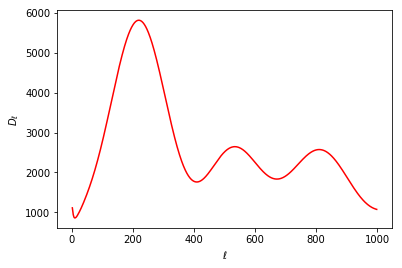

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

lmin, lmax = 2, 1000
l = np.arange(lmin, lmax)
Dl = Dl_tt[lmin:lmax]
plt.plot(l, Dl, "r")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$D_\ell$")

As we wil see later the `info` dictionary can be all declared within a `yaml` file to ease the `cobaya`'s
configuration.



## Using MINUIT sampler within cobaya



Given the previous simulated spectrum, we will now bin it and slightly disturbed it to apply the
MINUIT sampler and get back the best cosmological parameters from minimization.



### Binning and building an "observable" CMB spectrum



Let's define a function `bin_spectrum` that will compute the mean and its error on $D_\ell$ value
given a `delta_l` sample size



In [1]:
def bin_spectrum(Dl, l, lmin, lmax, delta_l):
    nbin = np.int(lmax/delta_l)
    lb = np.zeros(nbin)
    db = np.zeros(nbin)
    err_db = np.zeros(nbin)
    for i in range(nbin):
        idx = np.where((l>i*delta_l) & (l<(i+1)*delta_l))
        db[i] = np.mean(Dl[idx])
        lb[i] = np.mean(l[idx])
        err_db[i] = np.std(Dl[idx])/np.sqrt(np.alen(idx))
    idx = np.where(lb>lmin)
    lb, db, err_db = lb[idx], db[idx], err_db[idx]
    return lb, db, err_db

Bin the spectrum with a $\Delta\ell=30$ bin size and disturb it given the error bar



In [1]:
delta_l = 30
lb, Db, err_Db = bin_spectrum(Dl, l, lmin=lmin, lmax=lmax, delta_l=delta_l)
Db_obs = Db + err_Db * np.random.randn(np.alen(err_Db))

Let's plot everything together



# Out[249]:
Text(0.5, 0, '$\\ell$')

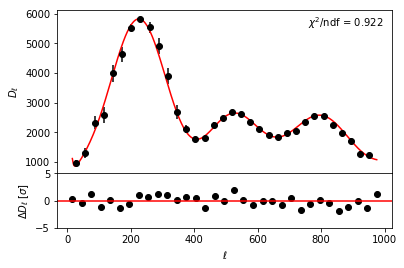

In [1]:
grid = plt.GridSpec(4, 1, hspace=0, wspace=0)
main = plt.subplot(grid[0:3], xticklabels=[])
main.plot(l, Dl, "red")
main.errorbar(lb, Db_obs, yerr=err_Db, fmt="ok")
main.set_ylabel(r"$D_\ell$")
chi2 = np.sum(((Db_obs - Db)/err_Db)**2)/np.alen(lb)
main.text(0.75, 0.9, r"$\chi^2$/ndf = {:.3f}".format(chi2),
          transform=main.transAxes)

dev = plt.subplot(grid[3], ylim=[-5,5])
dev.plot(lb, (Db_obs - Db)/err_Db, "ok")
dev.axhline(0, color="red")
dev.set_ylabel(r"$\Delta D_\ell\;[\sigma]$")
dev.set_xlabel(r"$\ell$")

### Setting-up the minimization program



Given the observable CMB spectrum *i.e.* `Db_obs` in our code, we will use MINUIT minimization algorithm
to find the best cosmological parameter values. In this tutorial, we will only minimize against the
spectrum amplitude $A_\text{s}$. All the other parameters will be fixed to their simulated values.

First we will define our likelihood



In [1]:
def chi2(_theory={"cl": {"tt": lmax}}):
        ls = np.arange(lmin, lmax)
        Dl_theo = _theory.get_cl(ell_factor=True)["tt"][lmin:lmax]
        lb, Db_theo, _ = bin_spectrum(Dl_theo, ls, lmin, lmax, delta_l)
        chi2 = np.sum(((Db_obs - Db_theo)/err_Db)**2)
        return -chi2

Our $\chi^2$ function will need to get the binned $D_\ell$ for every new set of cosmological
parameters. `cobaya` provides the `theory` block as a parameter of the function with name `_theory` that
must be respected. Since `cobaya` only deals with likelihood, we must return the negative value of
$\chi^2$ to make sure we maximize it over parameters (minimization process will minimize minus
likelihood). We should now tell `cobaya` to use our likelihood function



In [1]:
info["likelihood"] = {"chi2": chi2}

and that $A_\text{s}$ may vary given a flat prior on its value



In [1]:
info["params"]["As"] = {"prior": {"min": 1e-9, "max": 4e-9}}
info

#+begin_example
# Out[252]:
,#+BEGIN_EXAMPLE
  {'params': {'ombh2': 0.022,
  'omch2': 0.12,
  'H0': 68,
  'tau': 0.07,
  'As': {'prior': {'min': 1e-09, 'max': 4e-09}},
  'ns': 0.96,
  'mnu': 0.06,
  'nnu': 3.046,
  'num_massive_neutrinos': 1},
  'likelihood': {'chi2': <function __main__.chi2(_theory={'cl': {'tt': 1000}})>},
  'theory': {'camb': None}}
,#+END_EXAMPLE
#+end_example

To make sure everything has been set properly, we can slice our likelihood function along different
$A_\text{s}$ values



# Out[253]:
Text(0, 0.5, '$\\chi^2$')

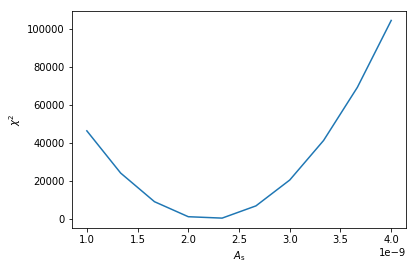

In [1]:
model = get_model(info)
As = np.linspace(1e-9, 4e-9, 10)
chi2s = [-model.loglike({"As": A})[0] for A in As]

plt.plot(As, chi2s)
plt.xlabel(r"$A_\mathrm{s}$")
plt.ylabel(r"$\chi^2$")

### Running MINUIT



Now that everything is set-up, we can run MINUIT. We still have to set the `sampler` method to `cobaya`



In [1]:
info["sampler"] = {"minuit": None}

with its default settings and do the minimization



In [1]:
from cobaya.run import run
updated_info, products = run(info)

The results of minimization are stored within the `products` variable which is a dictionary holding
the `cobaya` formated results



In [1]:
products["maximum"]

as well as the [`scipy.optimize.OptimizeResult`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html)



In [1]:
products["OptimizeResult"]

# Out[258]:
#+BEGIN_EXAMPLE
  fun: 30.39736787747739
  hess_inv: array([[3.0972107e-23]])
  message: 'Optimization terminated successfully.'
  minuit: <iminuit._libiminuit.Minuit object at 0x563b322a8fc8>
  nfev: 25
  njev: 0
  success: True
  x: array([2.20091268e-09])
#+END_EXAMPLE

We can plot the best $A_\text{s}$ value found by MINUIT



# Out[259]:

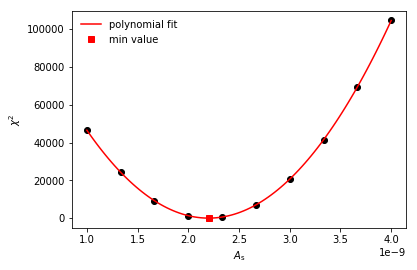

In [1]:
plt.plot(As, chi2s, "ok")
plt.xlabel(r"$A_\mathrm{s}$")
plt.ylabel(r"$\chi^2$")

# Fit with a 2nd order polynomial
p = np.poly1d(np.polyfit(As, chi2s, 2))
x = np.linspace(As[0], As[-1], 100)
plt.plot(x, p(x), "-r", label="polynomial fit")

minAs = products["OptimizeResult"].x
minChi2 = products["OptimizeResult"].fun
plt.plot(minAs, minChi2, "sr", label="min value")
plt.legend()

Next steps will be to relax other cosmological parameters&#x2026;



### Putting everything into yaml file



`cobaya` configuration can be done as in the example above, through the generation of dictionary that
must respect some name convention and other syntax rules (for instance, you can not name
cosmological parameters other than `params`). As your projet will grow, it may be useful to use a `yaml`
configuration file to tell `cobaya` which parameters, samplers or theory code you want to use. The
minimization configuration can be written as

    params:
      # Fixed
      ombh2: 0.022
      omch2: 0.12
      H0: 68
      tau: 0.07
      ns: 0.96
      mnu: 0.06
      nnu: 3.046
      num_massive_neutrinos: 1
      # Sampled
      As:
        prior:
          min: 2.0e-9
          max: 2.2e-9
    
      likelihood:
        chi2: import_module("my_chi2").chi2
    
      theory:
        camb:
          stop_at_error: False
    
      sampler:
        minuit:

where `my_chi2` refers to a `my_chi2.py` file holding the `chi2` function. More information on `yaml` syntax
can be found [here](https://pyyaml.org/wiki/PyYAMLDocumentation).

